# Hamster Vs Rat Image Classification

**Anggota:**

* Dita Anggreani  (Data Prepocessing & Visualisasi Data)
* Putri Andriyani (Error Analysis & Confussion Matrix)
* Rani Widya A    (Evaluasi Model & Testing Model)
* Angela Siadari  (Melatih Model & Visualisasi Model Accuracy dan Loss Plot)
* Helga Pricilla  (Import Library & Load Data)
* Tessa Agitha    (Membuat Model & Kompilasi Model dengan bbrp Parameter)

# Import Library

In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

# Load Data

In [4]:
class_names = ['Hamster', 'Rat']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Kami akan memuat gambar-gambar dan label-label yang diperlukan dari folder **/kaggle/input/hamster-vs-rat/Hamster_Vs_Rat_Dataset** dengan fungsi load_data.

In [5]:
def load_data():
   
    datasets = ['../input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/train_data', '../input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/test_data']
    output = []
    
    # Melakukan iterasi melalui set data latih (training set) dan data uji (test set).
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Melakukan iterasi melalui setiap folder yang sesuai dengan kategori tertentu.
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Melakukan iterasi melalui setiap gambar dalam folder kita.
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Mendapatkan nama path (alamat) dari gambar tersebut
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Membuka dan mengubah ukuran (resize) gambar 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Menambahkan gambar dan label yang sesuai ke output 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ../input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/train_data


100%|██████████| 200/200 [00:01<00:00, 145.26it/s]


Loading ../input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/test_data


100%|██████████| 105/105 [00:00<00:00, 148.57it/s]


In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Data Prepocessing

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Jumlah contoh data latih      : {}".format(n_train))
print ("Jumlah contoh data uji        : {}".format(n_test))
print ("Setiap gambar memiliki ukuran : {}".format(IMAGE_SIZE))

Jumlah contoh data latih      : 401
Jumlah contoh data uji        : 206
Setiap gambar memiliki ukuran : (150, 150)


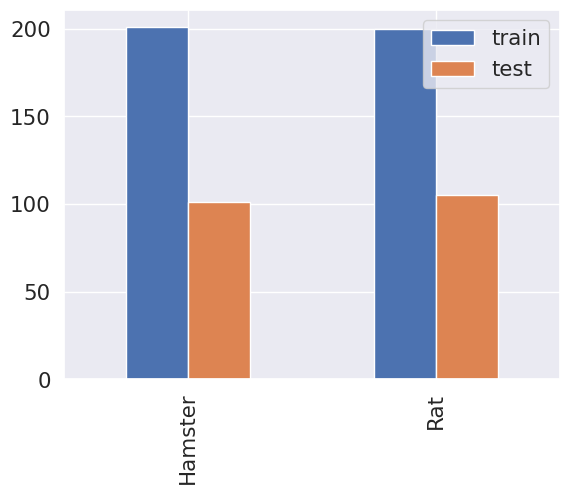

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

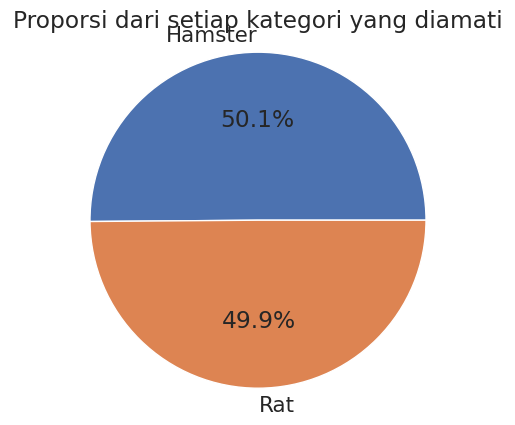

In [13]:
plt.pie(train_counts,
        explode=(0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporsi dari setiap kategori yang diamati')
plt.show()

## Mengukur ulang (skala) data

In [14]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Membuat visualisasi data
Kita dapat menampilkan sebuah gambar acak dari set data latih.

In [15]:
def display_random_image(class_names, images, labels):
    """
        Menampilkan sebuah gambar acak dari array gambar (images) dan label yang sesuai dari array label (labels).
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

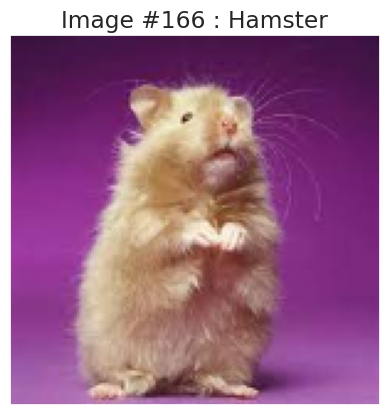

In [16]:
display_random_image(class_names, train_images, train_labels)

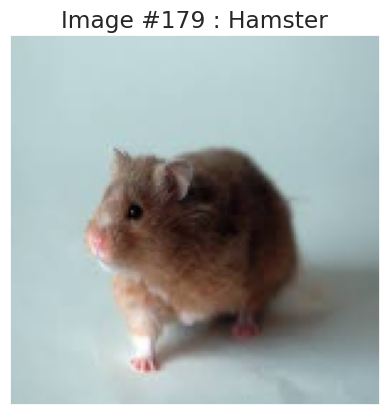

In [18]:
display_random_image(class_names, train_images, train_labels)

Kami akan menampilkan langsung 25 gambar pertama dari set data latih dengan menggunakan perulangan.

In [19]:
def display_examples(class_names, images, labels):
    """
        Menampilkan 25 gambar dari array gambar (images) beserta label-label yang sesuai
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

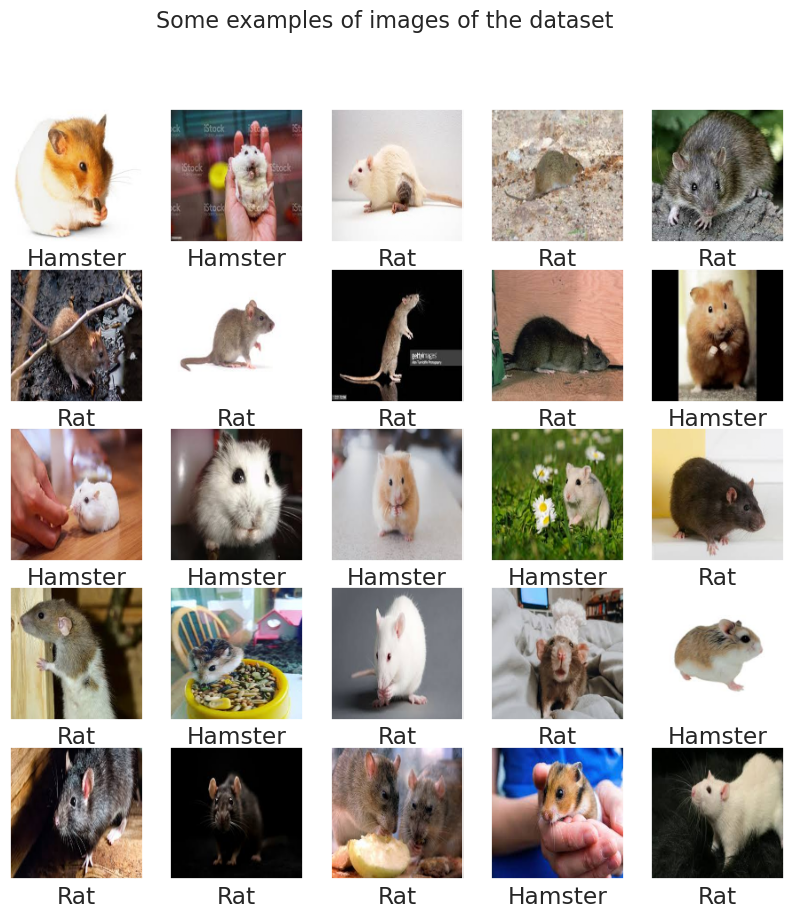

In [20]:
display_examples(class_names, train_images, train_labels)

# Model Development

Kami akan membangun sebuah model sederhana yang terdiri dari beberapa lapisan (layers) seperti berikut:

* Conv2D: (32 filter dengan ukuran 3x3) Fitur-fitur akan "diekstrak" dari gambar.
* MaxPooling2D: Gambar-gambar akan dikurangi ukurannya setengah.
* Flatten: Mengubah format gambar dari array 2D menjadi array 1D dengan panjang 150*150*3 nilai piksel.
* Relu: Diberikan suatu nilai x, mengembalikan nilai maksimum antara x dan 0.
* Softmax: 2 neuron, probabilitas bahwa gambar termasuk ke salah satu kelas.



In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

Selanjutnya, kita dapat mengompilasi model dengan beberapa parameter seperti:

* **Optimizer**: adam = RMSProp + Momentum. 
Apa itu Momentum dan RMSProp?
    * Momentum: Mengambil kalkulasi gradien masa lalu untuk mendapatkan pembaruan yang lebih baik.
    * RMSProp: Rata-rata tertimbang secara eksponensial dari kuadrat gradien masa lalu.
* **Loss function**: kita menggunakan sparse categorical crossentropy untuk klasifikasi, di mana setiap gambar hanya termasuk dalam satu kelas.

In [27]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

Kami melatih (fit) model menggunakan data dari set data latih. Neural network akan belajar sendiri pola-pola yang diperlukan untuk membedakan setiap kategori/klasifikasi.

In [29]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
3/3 [==============================] - 7s 2s/step - loss: 1.5143 - accuracy: 0.7406 - val_loss: 1.1642 - val_accuracy: 0.5556
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 0.5265 - accuracy: 0.7875 - val_loss: 0.7536 - val_accuracy: 0.5926
Epoch 3/20
3/3 [==============================] - 5s 2s/step - loss: 0.3944 - accuracy: 0.8125 - val_loss: 0.6598 - val_accuracy: 0.6420
Epoch 4/20
3/3 [==============================] - 5s 2s/step - loss: 0.3924 - accuracy: 0.8156 - val_loss: 0.6482 - val_accuracy: 0.6296
Epoch 5/20
3/3 [==============================] - 5s 2s/step - loss: 0.3617 - accuracy: 0.8906 - val_loss: 0.6598 - val_accuracy: 0.6420
Epoch 6/20
3/3 [==============================] - 5s 2s/step - loss: 0.3483 - accuracy: 0.8906 - val_loss: 0.6279 - val_accuracy: 0.6790
Epoch 7/20
3/3 [==============================] - 5s 2s/step - loss: 0.3160 - accuracy: 0.9219 - val_loss: 0.6912 - val_accuracy: 0.6296
Epoch 8/20
3/3 [=========================

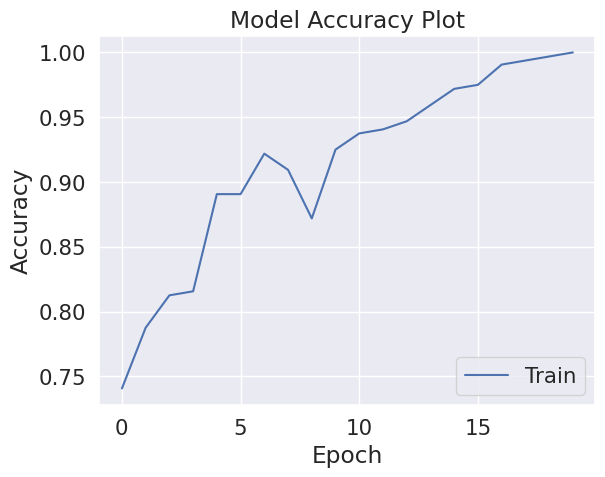

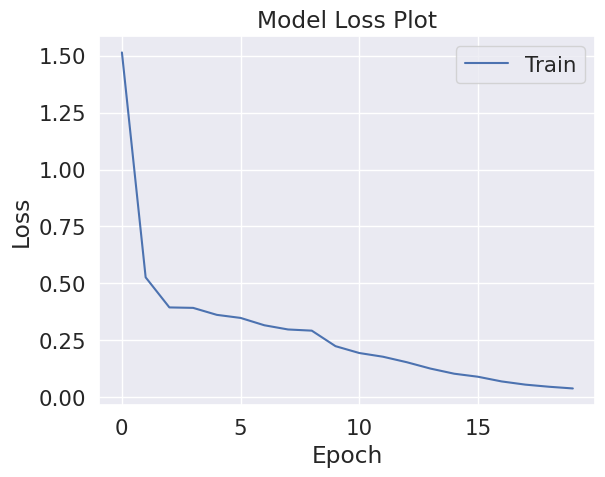

In [30]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# Model Testing dan Evaluation

Kami akan mengevaluasi kinerja model pada set data uji.

In [31]:
test_loss = model.evaluate(test_images, test_labels)

7/7 [==============================] - 1s 120ms/step - loss: 0.7755 - accuracy: 0.7330


Dapat dilihat bahwa kita mencapai akurasi sebesar 0.73 pada set data uji. Terdapat sedikit underfitting :(

Mari kita lihat bagaimana klasifikator ini berkerja pada gambar-gambar acak.

7/7 [==============================] - 1s 117ms/step


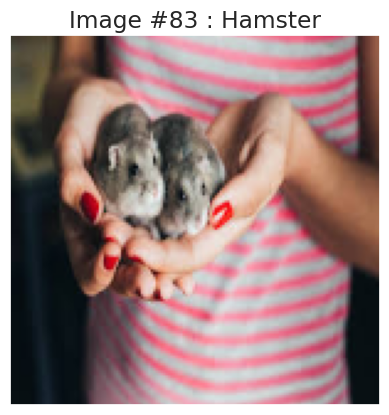

In [33]:
predictions = model.predict(test_images)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis = 1) # Kita mengambil probabilitas tertinggi.

display_random_image(class_names, test_images, pred_labels)

7/7 [==============================] - 1s 119ms/step


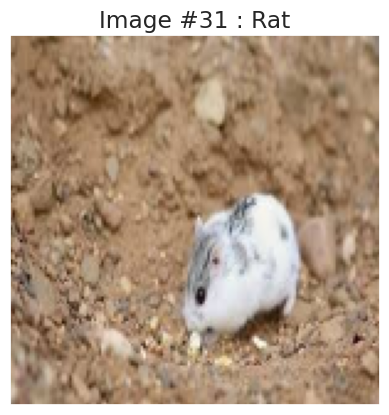

In [112]:
predictions = model.predict(test_images)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis = 1) # Kita mengambil probabilitas tertinggi.

display_random_image(class_names, test_images, pred_labels)

7/7 [==============================] - 1s 119ms/step


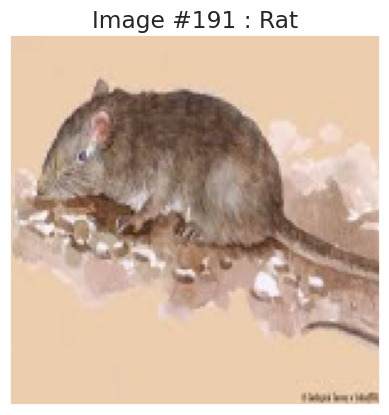

In [40]:
predictions = model.predict(test_images)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis = 1) # Kita mengambil probabilitas tertinggi.

display_random_image(class_names, test_images, pred_labels)

# Conclusion

## Kesimpulan:
Arsitektur dan parameter yang digunakan pada model ini menghasilkan akurasi sebesar 0.73 yang artinya model cukup bagus untuk memprediksi/mengklasifikan antara tikus dan hamster.

## Kelemahan:

Kadang masih terdapat kesalahan dalam membedakan tikus atau hamster. Untuk alasan kurang keakuratannya kemungkinan dikarenakan data uji & latih yang rendah. Untuk Alasan spesifik yang lain mungkin bisa dicoba dengan mengecek error analisis.

## Error analysis

Kita akan mencoba melihat jenis gambar mana yang menjadi kesulitan bagi klasifikator.

In [46]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Menampilkan 25 contoh gambar yang salah diklasifikasikan oleh klasifikator, yaitu ketika test_labels != pred_labels:
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


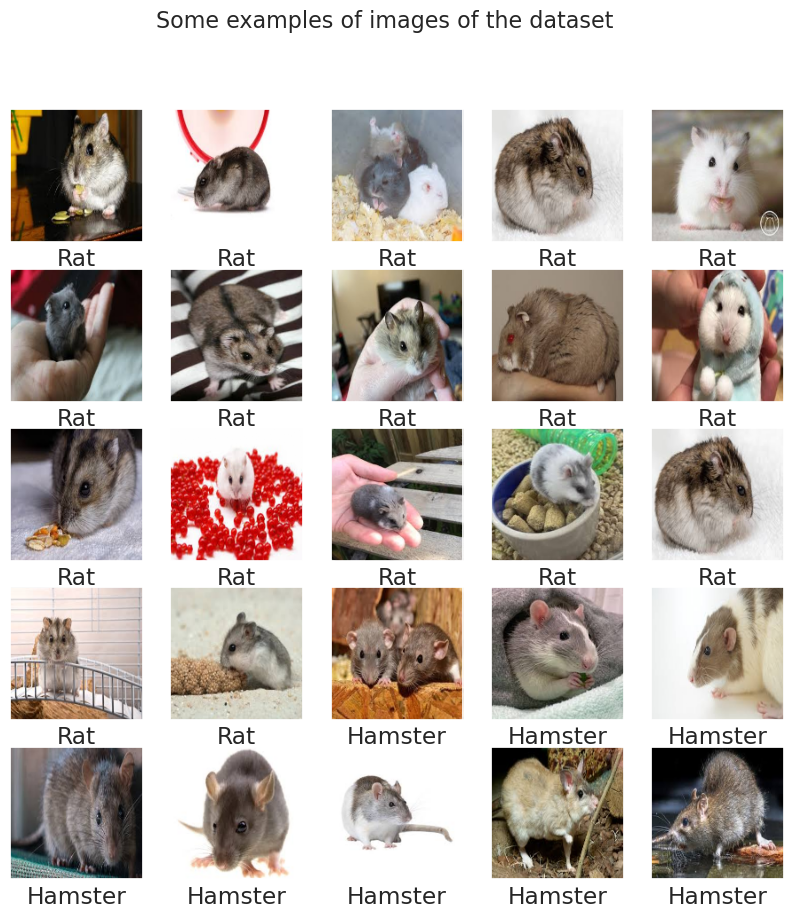

In [47]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

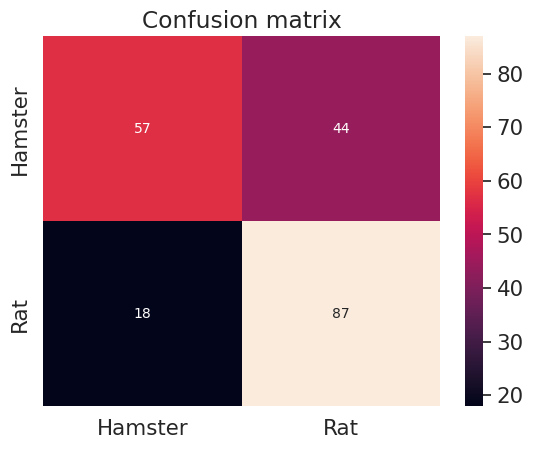

In [118]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Di sini kami akan mencoba menggunakan modelnya untuk memprediksi kelas dengan menggunakan data baru (di luar data uji & latih)

1/1 [==============================] - 0s 84ms/step


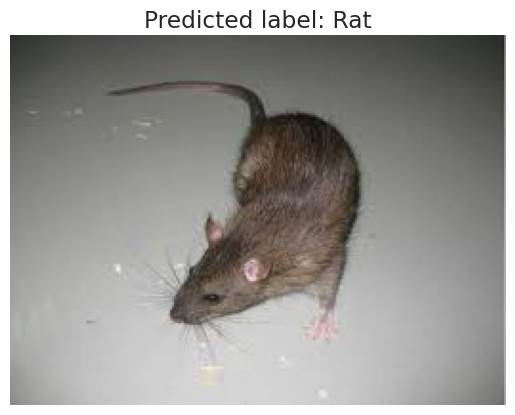

In [49]:
# Pra-pemrosesan data baru
image_path = "/kaggle/input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/predict_data/Rat/Rat16.jpg"
image = cv2.imread(image_path)
preprocessed_data = cv2.resize(image, (150, 150))  # Ubah ukuran gambar sesuai kebutuhan
preprocessed_data = preprocessed_data.reshape(1, 150, 150, 3)  # Ubah dimensi sesuai dengan model

# Prediksi dengan model
predictions = model.predict(preprocessed_data)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis=1)       # Mengambil probabilitas tertinggi

# Analisis hasil prediksi
predicted_label = class_names[pred_labels[0]]

# Menampilkan gambar inputan
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted label: {predicted_label}")
plt.show()

1/1 [==============================] - 0s 27ms/step


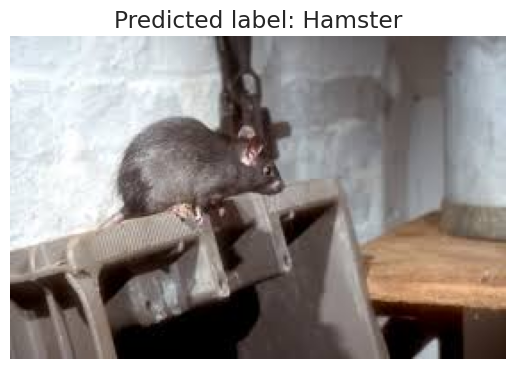

In [50]:
# Pra-pemrosesan data baru
image_path = "/kaggle/input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/predict_data/Rat/Rat23.jpg"
image = cv2.imread(image_path)
preprocessed_data = cv2.resize(image, (150, 150))  # Ubah ukuran gambar sesuai kebutuhan
preprocessed_data = preprocessed_data.reshape(1, 150, 150, 3)  # Ubah dimensi sesuai dengan model

# Prediksi dengan model
predictions = model.predict(preprocessed_data)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis=1)       # Mengambil probabilitas tertinggi

# Analisis hasil prediksi
predicted_label = class_names[pred_labels[0]]

# Menampilkan gambar inputan
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted label: {predicted_label}")
plt.show()


1/1 [==============================] - 0s 30ms/step


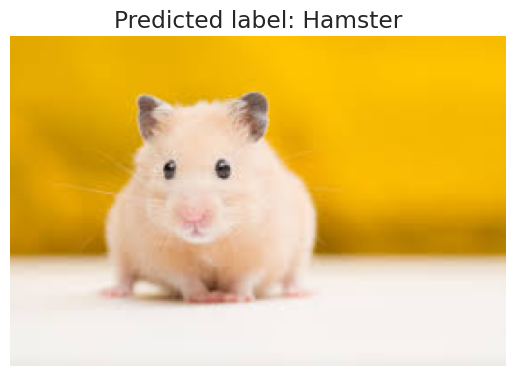

In [51]:
# Pra-pemrosesan data baru
image_path = "/kaggle/input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/predict_data/Hamster/Hamster24.jpg"
image = cv2.imread(image_path)
preprocessed_data = cv2.resize(image, (150, 150))  # Ubah ukuran gambar sesuai kebutuhan
preprocessed_data = preprocessed_data.reshape(1, 150, 150, 3)  # Ubah dimensi sesuai dengan model

# Prediksi dengan model
predictions = model.predict(preprocessed_data)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis=1)       # Mengambil probabilitas tertinggi

# Analisis hasil prediksi
predicted_label = class_names[pred_labels[0]]

# Menampilkan gambar inputan
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted label: {predicted_label}")
plt.show()

1/1 [==============================] - 0s 29ms/step


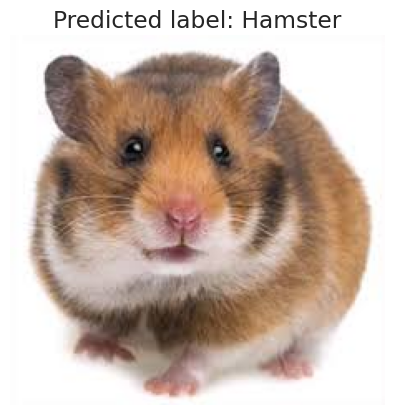

In [52]:
# Pra-pemrosesan data baru
image_path = "/kaggle/input/hamster-vs-rat/Hamster_Vs_Rat_Dataset/predict_data/Hamster/Hamster26.jpg"
image = cv2.imread(image_path)
preprocessed_data = cv2.resize(image, (150, 150))  # Ubah ukuran gambar sesuai kebutuhan
preprocessed_data = preprocessed_data.reshape(1, 150, 150, 3)  # Ubah dimensi sesuai dengan model

# Prediksi dengan model
predictions = model.predict(preprocessed_data)     # Vektor probabilitas
pred_labels = np.argmax(predictions, axis=1)       # Mengambil probabilitas tertinggi

# Analisis hasil prediksi
predicted_label = class_names[pred_labels[0]]

# Menampilkan gambar inputan
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted label: {predicted_label}")
plt.show()


## Analisis Kelemahan:

Kadang terdapat permasalahan dalam membedakan tikus atau hamster terutama pada inputan gambar yang tidak terlihat ciri utama perbedaan keduanya seperti ekor dan bentuk wajahnya. Apabila pada inputan gambar untuk diprediksi terlihat jelas ciri utama perbedaannya seperti ekor atau bentuk wajahnya, maka model dapat memprediksi dengan akurat.